In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import process_outputs as po
import pickle
import os
import copy
import socket
machine = socket.gethostname()
if 'trace' in machine:
    base_fp = '/trace/group/rounce/cvwilson/Output/'
else:
    base_fp = '/home/claire/research/Output/EB/'

In [2]:
# k = 0
# for setno in np.arange(0,128):
#     for j in range(5):
#         path = base_fp + f'01_22_0/grid_01_22_set{setno}_run{j}_0'
#         if os.path.exists(path+'.nc') and os.path.exists(path+'.pkl'):
#             ds = xr.open_dataset(path+'.nc')
#             # print(setno,k,ds.attrs)
#             # os.remove(path+'.nc')
#             w,s,a = seasonal_mass_balance(ds)
#             if np.any(np.abs([w,s,a]) > 4):
#                 print(w,s,a,'kw',ds.attrs['kw'],'kp',ds.attrs['kp'],'c5',ds.attrs['c5'])
#                 k += 1
#                 if k > 10:
#                     assert 1==0
#                 plot_seasonal_mass_balance(ds)
#                 plt.show()

In [3]:
# ds1,s,e = getds(base_fp+'Gulkana_2025_01_21_longAU_0.nc')
# for setn in [2]: #[0,1,2,3,4]:
#     setn += 5
#     ds2,s,e = getds(base_fp+f'01_21_0/grid_01_21_set{setn}_run0_0.nc')
#     # compare_runs([ds1,ds2],[s,e],['save run','grid search'],'melt',res='MS')
# #     if setn == 1:
# #         ds3 = ds2.copy(deep=True)
# #     # plot_seasonal_mass_balance(ds2)
# kw = '3'
# kp = '2.7'
# site = 'AU'
# # for c5 in ['0.018','0.02','0.022']: # 
# c5 = '0.02'
# set_no = result_dict[kw][c5][kp][site]['set_no']
# run_no = result_dict[kw][c5][kp][site]['run_no']
# ds4,s,e = getds(base_fp + f'01_16_0/grid_01_16_set{set_no}_run{run_no}_0.nc')
# compare_runs([ds1,ds2,ds4],[s,e],['save run','grid search','prior'],'melt',res='MS')
# plot_seasonal_mass_balance(ds4)

In [2]:
# Create some dictionaries with useful information
labels = {'kp':'Precipitation factor','kw':'Wind factor','Boone_c5':'Densification c$_5$'}      # Labels for the different parameters we varied
methodlabels = {'MAE':'MAE','ME':'Bias','RMSE':'RMSE'}                            # Labels for the different error methods
errorlabels = {'seasonal':'Seasonal mass balance (m w.e.)',                                     # Labels for the different error metrics with units
               'snowdepth':'End-of-winter snow depth (m)',
               'snowmass':'End-of-winter snow mass (m w.e.)',
               'snowdensity':'End-of-winter snow density (kg m-3)',
               '2024':'2024 surface height change (m)'} 
medians = {'kp':'2.6','kw':'1','Boone_c5':'0.024'}                                              # Median value of each of the parameters
sitedict = {'2024':['AB','ABB','B','BD','D','T'],'long':['A','AU','B','D']}                     # Dictionary of sites in the 2024 and long run
all_sites = sitedict['long']+sitedict['2024']+['mean']                                          # List all sites

In [3]:
# USER OPTIONS
method = 'ME'                                                      # Choose from MAE, ME
run_info = {'long':{'date':'01_22', 'idx':'0'},                     # Date and index of the grid search (12_04) (01_16)
            '2024':{'date':'12_06', 'idx':'0'}}                     # (12_06)
params = {'kw':[1,1.5,2,2.5,3],                                     # Parameters used in the grid search
          'Boone_c5':[0.018,0.02,0.022,0.024,0.026,0.028],
          'kp':[2.4,2.6,2.8,3,3.2]}
for key in params:                                                  # Convert params to strings for processing
    for v,value in enumerate(params[key]):
        params[key][v] = str(value)

In [4]:
# ===== Open or parse output dictionary for both runs =====
both_dict = {}
for run_type in ['long']: #,'2024']:
    date = run_info[run_type]['date']
    idx = run_info[run_type]['idx']
    if not os.path.exists(base_fp + f'{date}_{idx}_out.pkl'):
        # No compiled pickle exists: create dictionary
        grid_dict = {}
        for kw in params['kw']:
            grid_dict[kw] = {}
            for c5 in params['Boone_c5']:
                grid_dict[kw][c5] = {}
                for kp in params['kp']:
                    grid_dict[kw][c5][kp] = {}
                    for site in sitedict[run_type]:
                        grid_dict[kw][c5][kp][site] = {}

        for f in os.listdir(base_fp+f'{date}_{idx}/'):
            if 'pkl' in f:
                # Open individual output pickle 
                with open(base_fp + f'{date}_{idx}/' + f, 'rb') as file:
                    run_dict = pickle.load(file)
                set_no = f.split('_')[3].split('set')[1]
                run_no = f.split('_')[4].split('run')[1]
                kw = run_dict['kw']
                c5 = run_dict['c5']
                kp = run_dict['kp']
                site = run_dict['site']
                for var in run_dict:
                    if 'MAE' in var or 'ME' in var:
                        if type(run_dict[var]) == dict:
                            grid_dict[kw][c5][kp][site][var] = run_dict[var]['mean']
                        else:
                            grid_dict[kw][c5][kp][site][var] = run_dict[var]
                grid_dict[kw][c5][kp][site]['set_no'] = set_no
                grid_dict[kw][c5][kp][site]['run_no'] = run_no

        # Store compiled pickle
        with open(base_fp + f'{date}_{idx}_out.pkl', 'wb') as file:
            pickle.dump(grid_dict, file)
    else:
        # Compiled pickle exists: load it
        with open(base_fp + f'{date}_{idx}_out.pkl', 'rb') as file:
            grid_dict = pickle.load(file)
    
    # Store the dictionary under the run type (long or 2024)
    both_dict[run_type] = grid_dict

# Condense long and 2024 runs into to a single result_dict
result_dict = both_dict['long']
# for c5 in params['Boone_c5']:
#     for kp in params['kp']:
#         # Add the 2024 error stats to the result_dict
#         for site in sitedict['2024']:
#             # Some sites are different from long run, so add a slot for these runs
#             if site not in result_dict['1'][c5][kp]:
#                 result_dict['1'][c5][kp][site] = {}
#             # Add the 2024 error stats
#             for var in both_dict['2024']['1'][c5][kp][site]:
#                 result_dict['1'][c5][kp][site]['2024_'+var] = both_dict['2024']['1'][c5][kp][site][var]  

(<Figure size 600x300 with 1 Axes>, <Axes: ylabel='melt'>)

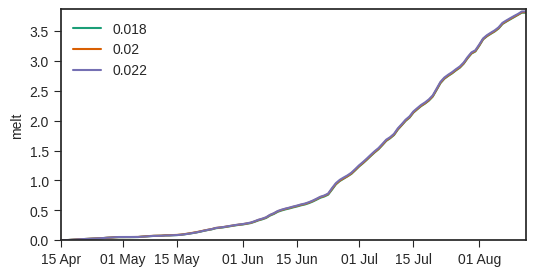

In [10]:
kkww = '2.5'
kkpp = '2.8'
site = 'A'
dslist = []
labels = []
for c5 in params['Boone_c5'][:3]:
    setno = result_dict[kkww][c5][kkpp][site]['set_no']
    runno = result_dict[kkww][c5][kkpp][site]['run_no']
    ds, s,e = getds(base_fp + f'01_24_0/grid_01_24_set{setno}_run{runno}_0.nc')
    # visualize_layers(ds,pd.date_range(s,e,freq='h'),)
    dslist.append(ds)
    labels.append(ds.attrs['c5'])
compare_runs(dslist,[s,s+pd.Timedelta(days=120)],labels,'melt')

In [11]:
4% 2 == 0

True

In [19]:
# ===== Find site means of each error type =====
# List out all error types
all_error = list(result_dict['1']['0.026']['2.4']['B'].keys())
all_error.remove('run_no')
all_error.remove('set_no')
all_error.remove('2024_run_no')
all_error.remove('2024_set_no')
    
# Create dictionary to store site means
sites_error_dict = {}
# Loop through all parameters and sites
for kw in params['kw']:
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            result_dict[kw][c5][kp]['mean'] = {}
            for error_type in all_error:
                sites_error_dict[error_type] = []
                for site in all_sites[:-1]:
                    if '2024' in error_type and site in sitedict['2024'] and kw == '1':
                        sites_error_dict[error_type].append(result_dict[kw][c5][kp][site][error_type])
                    elif '2024' not in error_type and site in sitedict['long']:
                        sites_error_dict[error_type].append(result_dict[kw][c5][kp][site][error_type])
                if len(sites_error_dict[error_type]) > 0:
                    result_dict[kw][c5][kp]['mean'][error_type] = np.mean(sites_error_dict[error_type])

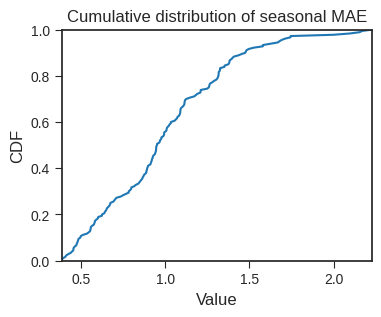

In [6]:
# ===== Plot the cumulative distribution function for error metrics =====
# Choose error type to plot
error_type = 'seasonal_MAE'
plot_site = 'mean'
fig,ax = plt.subplots(figsize=(4,3))

# List out all errors in that type
error_list = []
kws = params['kw'] if '2024' not in error_type else ['1']
for kw in kws:
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            error_list.append(result_dict[kw][c5][kp][plot_site][error_type])

# Evaluate CDF
sorted_list = np.sort(error_list)
cdf = np.arange(1, len(sorted_list)+1) / len(sorted_list)

# Plot
ax.plot(sorted_list, cdf)
ax.set_xlabel('Value',fontsize=12)
ax.set_ylabel('CDF',fontsize=12)
ax.set_ylim(0,1)
ax.set_xlim(sorted_list[0],sorted_list[-1])
ax.tick_params(length=5)
label = error_type.replace('_',' ').replace('snow','snow ')
ax.set_title(f'Cumulative distribution of {label}')
plt.show()

In [7]:
ds1 = xr.open_dataset(base_fp+'Gulkana_2025_01_21_longAU_0.nc')
ds1

<xarray.Dataset> Size: 576MB
Dimensions:         (time: 108133, layer: 80)
Coordinates:
  * time            (time) datetime64[ns] 865kB 2012-04-20 ... 2024-08-20T12:...
  * layer           (layer) int64 640B 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79
Data variables: (12/33)
    melt            (time) float64 865kB ...
    refreeze        (time) float64 865kB ...
    runoff          (time) float64 865kB ...
    accum           (time) float64 865kB ...
    snowdepth       (time) float64 865kB ...
    cumrefreeze     (time) float64 865kB ...
    ...              ...
    layergrainsize  (time, layer) float64 69MB ...
    layerrefreeze   (time, layer) float64 69MB ...
    SWnet           (time) float64 865kB ...
    LWnet           (time) float64 865kB ...
    NetRad          (time) float64 865kB ...
    MB              (time) float64 865kB ...
Attributes: (12/13)
    from_AWS:         none
    from_reanalysis:  MERRA2: all
    run_start:        2012-04-20 00:00:00
    run_end:          2024-08-20 12:00
    elevation:        1442.0 m a.s.l.
    model_run_date:   2025-01-21 18:14:53.950023
    ...               ...
    switch_snow:      1
    switch_LAPs:      1
    time_elapsed:     1839.4023163318634 s
    run_by:           trace01.wec.local.cmu.edu
    glacier:          Gulkana
    site:             AU

In [8]:
kkww = '3'
kkpp = '2.6'
site = 'AU'
dslist = [ds1]
labels = ['actual']
for c5 in params['Boone_c5'][2:3]:
    setno = result_dict[kkww][c5][kkpp][site]['set_no']
    runno = result_dict[kkww][c5][kkpp][site]['run_no']
    ds, s,e = getds(base_fp + f'01_22_0/grid_01_22_set{setno}_run{runno}_0.nc')
    print(ds.attrs)
    dslist.append(ds)
    labels.append(ds.attrs['c5'])
    # simple_plot(ds,['2015-04-20','2015-07-20'],[['SWnet'],['layerBC','layerdust'],['layergrainsize']],res='d')
    # visualize_layers(ds,pd.date_range('2015-04-20','2015-05-10',freq='h'),['layerdensity','layerBC'],ylim=1)
    # plt.show()

{'kw': '3', 'c5': '0.022', 'kp': '2.6', 'site': 'AU', 'from_AWS': 'none', 'from_reanalysis': 'MERRA2: all', 'run_start': '2012-04-20 00:00:00', 'run_end': '2024-08-20 00:00:00', 'elevation': '1442.0 m a.s.l.', 'model_run_date': '2025-01-22 23:08:48.202882', 'switch_melt': '2', 'switch_snow': '1', 'switch_LAPs': '1', 'time_elapsed': '1972.3204872608185 s', 'run_by': 'trace06.wec.local.cmu.edu', 'glacier': 'Gulkana'}


(<Figure size 600x300 with 1 Axes>, <Axes: ylabel='latent'>)

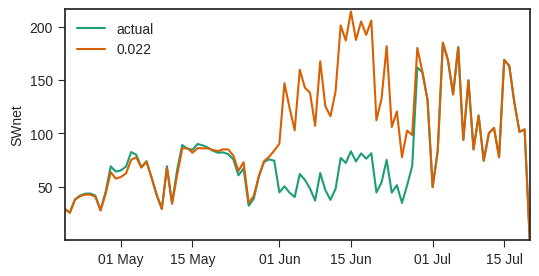

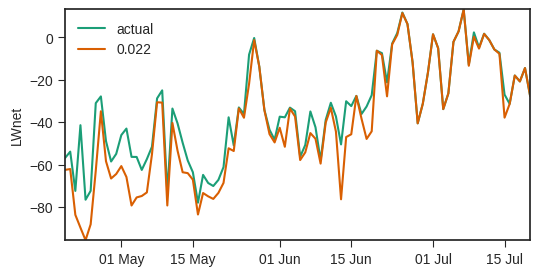

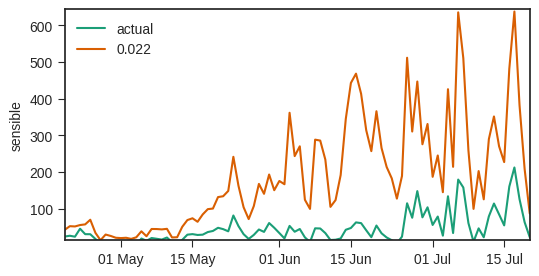

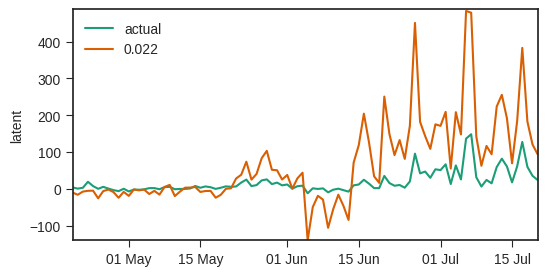

In [9]:

compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'SWnet')
compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'LWnet')
compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'sensible')
compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'latent')

(<Figure size 600x300 with 1 Axes>, <Axes: ylabel='surftemp'>)

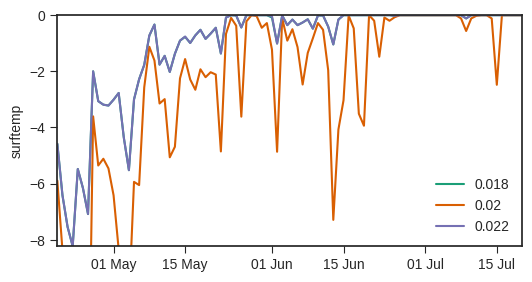

In [53]:
compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'surftemp')

(<Figure size 600x300 with 1 Axes>, <Axes: ylabel='latent'>)

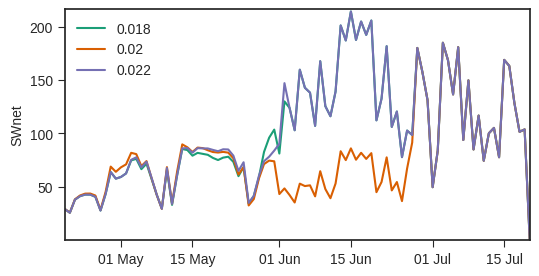

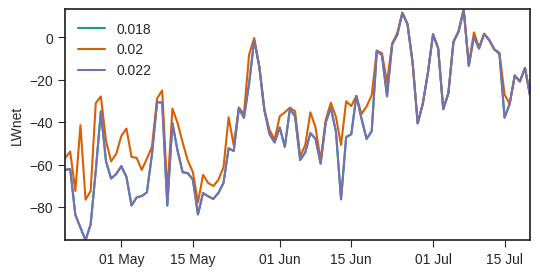

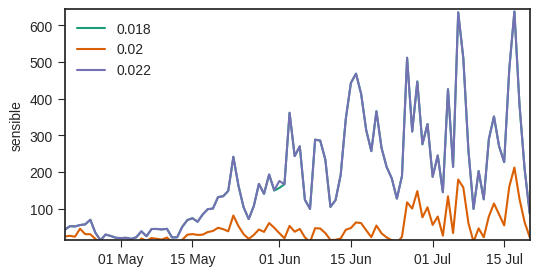

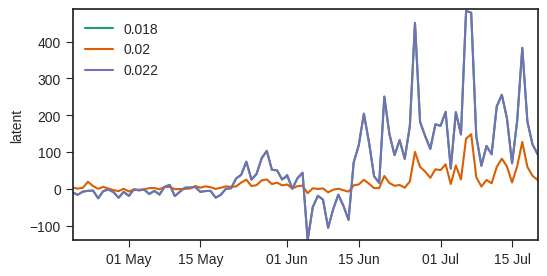

In [44]:

compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'SWnet')
compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'LWnet')
compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'sensible')
compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'latent')
# compare_runs(dslist,['2015-04-20','2015-07-20'],labels,'layergrainsize')

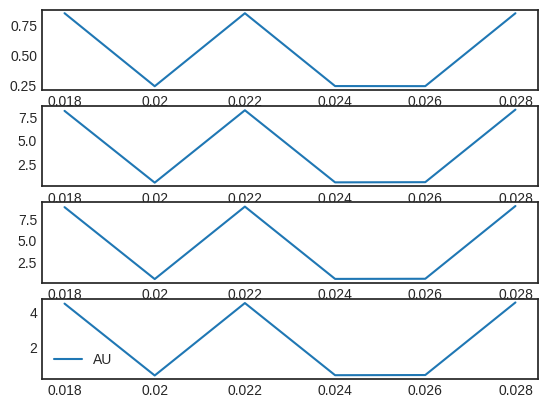

In [26]:
kkww = '3'
kkpp = '2.6'
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4)
# for site in ['A','AU','B','D']:
for site in ['AU']:
    l = []
    b = []
    a = []
    ss = []
    for c5 in params['Boone_c5']:
        l.append(result_dict[kkww][c5][kkpp][site]['winter_MAE'])
        b.append(result_dict[kkww][c5][kkpp][site]['summer_MAE'])
        a.append(result_dict[kkww][c5][kkpp][site]['annual_MAE'])
        ss.append(result_dict[kkww][c5][kkpp][site]['seasonal_MAE'])

    ax1.plot(params['Boone_c5'],l,label=site+' winter')
    ax2.plot(params['Boone_c5'],b,label=site+' summer')
    ax3.plot(params['Boone_c5'],a,label=site)
    ax4.plot(params['Boone_c5'],ss,label=site)

plt.legend()

In [9]:
# ===== Normalize error between 0-1 for the min-max of a given metric =====
# Set bounds for what we consider a bad run
error_lims = {'2024_MAE':0.5,'snowdensity_MAE':100,'seasonal_MAE':1,'snowdepth_MAE':0.8}

# Create storage for minimum/maximum error of each error type
error_extremes_dict = {}
for site in all_sites:
    error_extremes_dict[site] = {}
    for error_type in all_error:
        error_extremes_dict[site][error_type] = {'min':np.inf,'max':0}

# Go through every error and store the extremes
for kw in params['kw']:
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            for site in all_sites:
                if site in result_dict[kw][c5][kp]:
                    for error_type in result_dict[kw][c5][kp][site]:
                        current_value = result_dict[kw][c5][kp][site][error_type]

                        # Check if it's a bad run and skip if so
                        if error_type in error_lims:
                            if current_value > error_lims[error_type]:
                                continue
                        else:
                            continue

                        # Acceptable run: compare error metrics to the running extremes
                        if current_value < error_extremes_dict[site][error_type]['min']:
                            error_extremes_dict[site][error_type]['min'] = current_value
                        if current_value > error_extremes_dict[site][error_type]['max']:
                            error_extremes_dict[site][error_type]['max'] = current_value

# Divide each value by the minimum to get error_norm
for kw in params['kw']:
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            for site in all_sites:
                if site in result_dict[kw][c5][kp]:
                    list_errors = copy.deepcopy(result_dict[kw][c5][kp][site])
                    for error_type in list_errors:
                        if 'norm' not in error_type:
                            current_value = result_dict[kw][c5][kp][site][error_type]
                            min_value = error_extremes_dict[site][error_type]['min']
                            max_value = error_extremes_dict[site][error_type]['max']
                            if min_value < np.inf and max_value > 0:
                                scaled_value = (current_value - min_value) / (max_value - min_value)
                                result_dict[kw][c5][kp][site][error_type+'_norm'] = scaled_value
                            else:
                                result_dict[kw][c5][kp][site][error_type+'_norm'] = np.inf

In [21]:
# Create function to find the pareto front points
def pareto_sweep(points):
    """
    Returns the indices of the pareto front points in the passed array
    """
    # Sort points by x-coordinate, then by y-coordinate
    sorted_indices = np.argsort(points[:, 0])
    sorted_points = points[sorted_indices]
    
    pareto_indices = []
    current_min_y = np.inf

    for i, point in enumerate(sorted_points):
        if point[1] < current_min_y: # F
            pareto_indices.append(sorted_indices[i])  # Store the original index
            current_min_y = point[1]

    return np.array(pareto_indices)

Comparing 2024 and seasonal MAE results in the following non-dominated sets:
    kw=1.0    c5=0.028    kp=2.6    2024 MAE=0.172   seasonal MAE=0.883
    kw=1.0    c5=0.028    kp=2.5    2024 MAE=0.187   seasonal MAE=0.836
    kw=1.0    c5=0.028    kp=2.4    2024 MAE=0.203   seasonal MAE=0.808
Comparing 2024 and snowdensity MAE results in the following non-dominated sets:
    kw=1.0    c5=0.028    kp=2.6    2024 MAE=0.172   snowdensity MAE=84.408
    kw=1.0    c5=0.028    kp=2.5    2024 MAE=0.187   snowdensity MAE=84.230
    kw=1.0    c5=0.028    kp=2.4    2024 MAE=0.203   snowdensity MAE=82.661
    kw=1.0    c5=0.026    kp=3.0    2024 MAE=0.203   snowdensity MAE=69.978
    kw=1.0    c5=0.026    kp=2.7    2024 MAE=0.207   snowdensity MAE=66.268
    kw=1.0    c5=0.026    kp=2.6    2024 MAE=0.214   snowdensity MAE=64.659
    kw=1.0    c5=0.026    kp=2.5    2024 MAE=0.230   snowdensity MAE=64.152
    kw=1.0    c5=0.024    kp=3.0    2024 MAE=0.245   snowdensity MAE=54.643
    kw=1.0    c5=0.

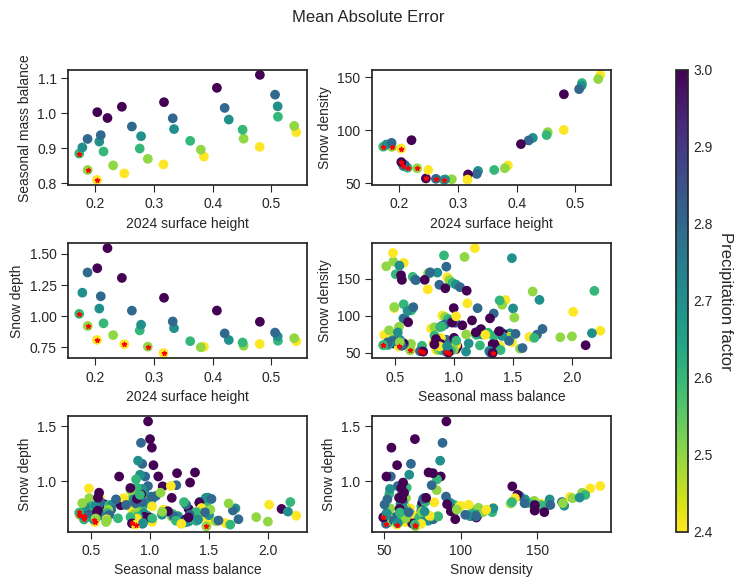

In [ ]:
# Make subplots for error vs. error (with space for colorbar)
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(3, 3, width_ratios=[1, 1, 0.05], wspace=0.4, hspace=0.5)
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(6)]

# Style
colored_param = 'kp'
metric = 'MAE'
norm = mpl.colors.Normalize(vmin=2.4,vmax=3)
cmap = mpl.colormaps.get_cmap('viridis_r')
styles = ['-','--',':','dashdot',(0, (1, 5)),(0, (5, 5))]
markers = ['o','^','*','x','+','>']

# Labels
param_labels = {'kw':'Wind factor','kp':'Precipitation factor','c5':'Densification parameter'}
shorterrorlabels = {'2024':'2024 surface height','snowdensity':'Snow density', 'snowdepth':'Snow depth','seasonal':'Seasonal mass balance'}

# List all error metrics to compare
plot_errors = ['2024','seasonal','snowdensity','snowdepth']
all_pareto_fronts = []
for i, (error_x, error_y) in enumerate(itertools.combinations(plot_errors,2)):
    ax = axes[i]
    if '2024' in [error_x,error_y]:
        kws = ['1']
    else:
        kws = params['kw']

    list_x = []
    list_y = []
    list_params = {'kw':[],'c5':[],'kp':[]}
    for kw in kws:
        for c5 in params['Boone_c5']:
            for kp in params['kp']:
                error_x_point = result_dict[kw][c5][kp]['mean'][error_x + '_' + metric]
                error_y_point = result_dict[kw][c5][kp]['mean'][error_y + '_' + metric]

                # Add to lists
                list_params['kw'].append(float(kw))
                list_params['c5'].append(float(c5))
                list_params['kp'].append(float(kp))
                list_x.append(error_x_point)
                list_y.append(error_y_point)

    # Plot
    ax.scatter(list_x,list_y,color=cmap(norm(list_params[colored_param]))) 
    ax.set_xlabel(shorterrorlabels[error_x],fontsize=10)
    ax.set_ylabel(shorterrorlabels[error_y],fontsize=10)  
    ax.tick_params(length=5)    
    
    # Non=dominated
    idx_non_dom = pareto_sweep(np.array([list_x,list_y]).T)
    print(f'Comparing {error_x} and {error_y} {metric} results in the following non-dominated sets:')
    fronts = []
    for i in idx_non_dom:
        kw = list_params['kw'][i]
        c5 = list_params['c5'][i]
        kp = list_params['kp'][i]
        print(f'    kw={kw}    c5={c5}    kp={kp}    {error_x} {metric}={list_x[i]:.3f}   {error_y} {metric}={list_y[i]:.3f}')
        fronts.append((kw,c5,kp))
        ax.scatter(list_x[i],list_y[i],marker='*',color='red',s=10)
    all_pareto_fronts.append(fronts)

sm = mpl.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
cbar_ax = fig.add_subplot(gs[:, 2])
cbar = fig.colorbar(sm, orientation='vertical',cax=cbar_ax)
cbar.set_label(param_labels[colored_param],rotation=270,labelpad=15,fontsize=12)
fig.suptitle(methodlabels[metric])
# ax.set_ylim(0,1)
# ax.set_xlim(0,1)
plt.savefig(base_fp+f'all_error_colored_{colored_param}_{metric}.png',bbox_inches='tight',dpi=180)
plt.show()

Text(0.5, 0.98, 'PDF of simulation bias of Pareto front parameter sets')

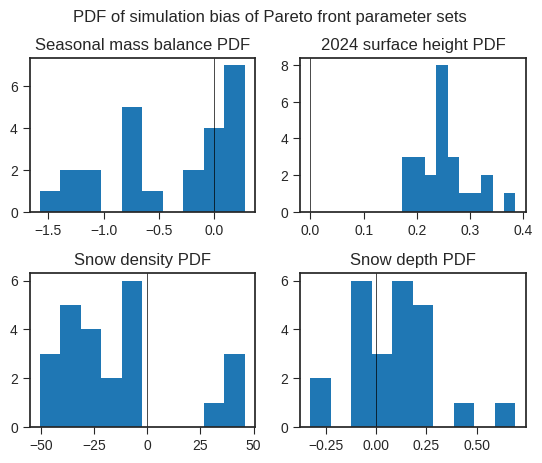

In [28]:
errors_list = {'seasonal':[],'2024':[],'snowdensity':[],'snowdepth':[]}
metric = 'ME'
plot_type = 'PMF'
for list_front in all_pareto_fronts[3:]:
    for (kw,c5,kp) in list_front:
        kw = str(kw).replace('.0','')
        c5 = str(c5)
        kp = str(kp).replace('.0','')
        errors_list['seasonal'].append(result_dict[kw][c5][kp]['mean']['seasonal_'+metric])
        errors_list['2024'].append(result_dict['1'][c5][kp]['mean']['2024_'+metric])
        errors_list['snowdensity'].append(result_dict[kw][c5][kp]['mean']['snowdensity_'+metric])
        errors_list['snowdepth'].append(result_dict[kw][c5][kp]['mean']['snowdepth_'+metric])
fig,axes = plt.subplots(2,2,gridspec_kw={'hspace':0.4})
axes = axes.flatten()
for i,ax in enumerate(axes):
    errors = errors_list[list(errors_list.keys())[i]]
    if plot_type == 'CDF':
        sorted_list = np.sort(errors)
        cdf = np.arange(1, len(sorted_list)+1) / len(sorted_list)
        ax.plot(sorted_list, cdf)
    elif plot_type == 'PMF':
        ax.hist(errors, bins=10)
        ax.axvline(0,linewidth=0.5,color='black')
    elif plot_type == 'PDF':
        ax.hist(errors, bins=10,density=True)
        ax.axvline(0,linewidth=0.5,color='black')
    ax.set_title(shorterrorlabels[list(errors_list.keys())[i]]+' '+plot_type)
    ax.tick_params(length=5)
fig.suptitle(f'{plot_type} of simulation bias of Pareto front parameter sets')
plt.savefig(base_fp+f'pareto_{metric}_{plot_type}.png',dpi=180,bbox_inches='tight')

In [17]:
# Determine which parameters are consistent across all comparisons
sets_of_tuples = [set(sublist) for sublist in all_pareto_fronts]
consistent_parameters = set.intersection(*sets_of_tuples)
print(consistent_parameters)

set()


In [18]:
weights = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],
            [0.25,0.25,0.25,0.25]]
error_1 = '2024_MAE_norm'
error_2 = 'seasonal_MAE_norm'
error_3 = 'snowdensity_MAE_norm'
error_4 = 'snowdepth_MAE_norm'

# Loop through weights
for weight in weights:
    w1,w2,w3,w4 = weight
    assert np.abs(np.sum(weight) - 1) < 1e-3
    weighted_list = []
    for kw in params['kw']:
        for c5 in params['Boone_c5']:
            for kp in params['kp']:
                o1 = result_dict['1'][c5][kp]['mean'][error_1]
                o2 = result_dict[kw][c5][kp]['mean'][error_2]
                o3 = result_dict[kw][c5][kp]['mean'][error_3]
                o4 = result_dict[kw][c5][kp]['mean'][error_4]
                weighted_error = o1*w1 + o2*w2 + o3*w3 + o4*w4
                if len(weighted_list) > 0 and weighted_error < np.min(weighted_list):
                    best = (kw,c5,kp)
                    best_error = weighted_error
                weighted_list.append(weighted_error)
    # weighted_error = np.mean(weighted_list)
    print('Weighing error metrics by:')
    print('   ',error_1,': ', w1)
    print('   ',error_2,': ', w2)
    print('   ',error_3,': ', w3)
    print('   ',error_4,': ', w4)
    print('      results in best set of:',best)

Weighing error metrics by:
    2024_MAE_norm :  1
    seasonal_MAE_norm :  0
    snowdensity_MAE_norm :  0
    snowdepth_MAE_norm :  0
      results in best set of: ('1', '0.028', '2.6')
Weighing error metrics by:
    2024_MAE_norm :  0
    seasonal_MAE_norm :  1
    snowdensity_MAE_norm :  0
    snowdepth_MAE_norm :  0
      results in best set of: ('3', '0.026', '2.4')
Weighing error metrics by:
    2024_MAE_norm :  0
    seasonal_MAE_norm :  0
    snowdensity_MAE_norm :  1
    snowdepth_MAE_norm :  0
      results in best set of: ('2.5', '0.024', '3')
Weighing error metrics by:
    2024_MAE_norm :  0
    seasonal_MAE_norm :  0
    snowdensity_MAE_norm :  0
    snowdepth_MAE_norm :  1
      results in best set of: ('2', '0.028', '2.5')
Weighing error metrics by:
    2024_MAE_norm :  0.25
    seasonal_MAE_norm :  0.25
    snowdensity_MAE_norm :  0.25
    snowdepth_MAE_norm :  0.25
      results in best set of: ('3', '0.026', '2.6')


PLOT TIMESERIES OF THE BEST RUNS

In [ ]:
# for ss,site in enumerate(['A','AU','B','D']):
#     if 'run' in result_dict['long'][kw][c5][kp][site]:
#         run = result_dict['long'][kw][c5][kp][site]['run']
#         set = result_dict['long'][kw][c5][kp][site]['set']
#         print(result_dict['long'][kw][c5][kp][site],kw,c5,kp)
#         ds,s,e = getds(base_fp + f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
#         plot_seasonal_mass_balance(site,ds)
#         # print(ds.attrs)

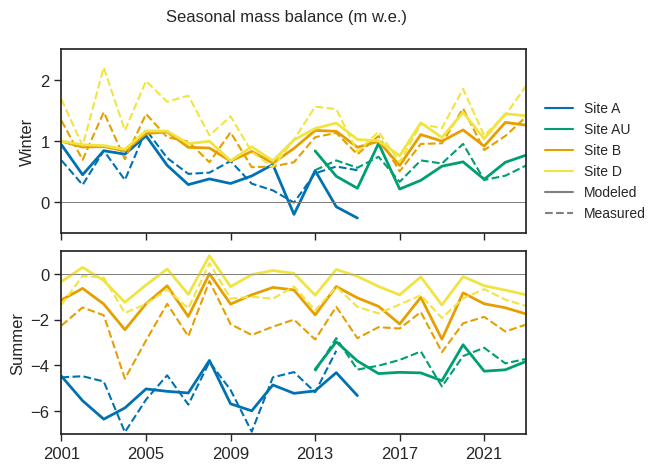

In [21]:
fig, axes = plt.subplots(2,figsize=(6,5),gridspec_kw={'hspace':0.1},sharex=True)
list_plots = []
sites = ['A','AU','B','D']
colors = np.flip(['#F0E442','#E69F00','#009E73','#0072B2']) #
date = run_info['long']['date']
idx = run_info['long']['idx']

for ss,site in enumerate(sites):
    # if 'run' in result_dict['long'][kw][c5][kp][site]:
    #     run = result_dict['long'][kw][c5][kp][site]['run']
    #     set = result_dict['long'][kw][c5][kp][site]['set']
    #     ds,s,e = getds(base_fp + f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
    # else:
    #     continue        
    ds,s,e = getds(base_fp + f'Gulkana_2024_12_20_long{site}_0.nc')

    color = colors[ss]
    axes[0] = plot_seasonal_mass_balance(ds,plot_ax=axes[0],plot_var='bw',color=color)
    axes[1] = plot_seasonal_mass_balance(ds,plot_ax=axes[1],plot_var='bs',color=color)
    dummy_site, = axes[1].plot(np.nan,np.nan,color=color)
    list_plots.append(dummy_site)
dummy_model, = axes[1].plot(np.nan,np.nan,color='gray')
dummy_meas, = axes[1].plot(np.nan,np.nan,color='gray',linestyle='--')
list_plots.append(dummy_model)
list_plots.append(dummy_meas)
axes[0].set_ylabel('Winter',fontsize=12)
axes[1].set_ylabel('Summer',fontsize=12)
axes[0].set_ylim(-0.5,2.5)
axes[1].set_ylim(-7,1)
axes[1].set_yticks([0,-2,-4,-6])
for i in range(2):
    axes[i].get_legend().remove()
labels = ['Site '+sss for sss in sites]+['Modeled','Measured']
fig.legend(list_plots,labels,bbox_to_anchor=(1.12,0.8),fontsize=10)
fig.suptitle('Seasonal mass balance (m w.e.)',fontsize=12,y=0.96)
# plt.savefig(base_fp+'seasonal_mass_balance.png',dpi=180,bbox_inches='tight')
plt.show()
    # fig, ax = seasonal_mass_balance(site,ds,plot=True)
    # visualize_layers(ds,pd.date_range(s,e,freq='MS'),['layertemp'],plot_ice=True,ylim=55)
    # simple_plot(ds,['2006-08-11','2006-08-12'],[['sensible','latent','SWnet','LWnet','meltenergy']],res='h')
    # ds = ds.resample(time='MS').mean()
    # # ds = ds.sel(time=pd.date_range('2006-05-20','2006-07-30',freq='h'))
    # plt.plot(ds.time.values,ds.sensible+ds.latent+ds.SWnet+ds.LWnet+ds.rain+ds.ground)
    # plt.plot(ds.time.values,ds.meltenergy)
    # plt.show()
    # fig.savefig(f'/trace/group/rounce/cvwilson/Output/best_{site}_{date}.png',dpi=180,bbox_inches='tight')

Site AB internal acc: 0.00001 m w.e.
Site B internal acc: 0.00005 m w.e.
Site D internal acc: 0.07979 m w.e.
Site T internal acc: 0.09644 m w.e.


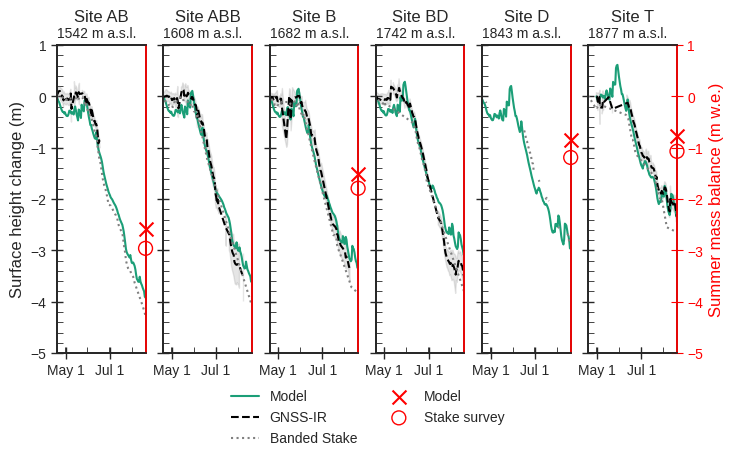

In [8]:
elev = {'AB':1542,'ABB':1608,'B':1682,'BD':1742,'D':1843,'T':1877}
ylim = (-5,1)
fig,axes = plt.subplots(1,6,figsize=(8,4),sharey=True,sharex=True,gridspec_kw={'wspace':0.2})
date = run_info['2024']['date']
idx = run_info['2024']['idx']
for i,site in enumerate(['AB','ABB','B','BD','D','T']):
    # if 'run' in result_dict['2024'][site]['1'][c5][kp]:
    #     run = result_dict['2024'][site]['1'][c5][kp]['run']
    #     set = result_dict['2024'][site]['1'][c5][kp]['set']
    #     ds,s,e = getds(base_fp + f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
    # else:
    #     continue
    ds,s,e = getds(base_fp + f'/Gulkana_12_20_2024{site}_0.nc')

    if site == 'B':
        bds = ds.copy(deep=True)
    axes[i] = plot_2024_mass_balance(ds,plot_ax=axes[i])
    axes[i].set_title(f'Site {site}',fontsize=12,y=1.05)
    axes[i].text(pd.to_datetime('2024-04-20'),1.15,str(elev[site])+' m a.s.l.',fontsize=10)
    axes[i].set_ylabel('')
    # direction = '' if error < 0 else '+'
    # text = f'{direction}{error:.3f} m'
    # axes[i].text(enddate-pd.Timedelta(days=80),0.9,text,fontsize=10)
    
    axes[i].get_legend().remove()
    axes[i].set_xlim(s,e)
    axes[i].set_xticks(pd.date_range(s,e,freq='2MS'))
    axes[i].tick_params(labelsize=10,direction='inout',length=8)
    axes[i].minorticks_on()
    axes[i].tick_params(which='minor', direction='in', length=4)
    axes[i].set_xticklabels(['May 1','Jul 1'])
    axes[i].xaxis.set_minor_locator(mpl.dates.MonthLocator(interval=1))
    twinax = axes[i].twinx()
    if site not in ['ABB','BD']:
        mbmod,mbmeas = cumulative_mass_balance(ds,out_mbs=True)
        mod = twinax.scatter(e,mbmod,color='red',marker='x',s=100)
        meas = twinax.scatter(e,mbmeas,color='red',marker='o',facecolors='none',s=100)
        meas.set_clip_on(False)
        mod.set_clip_on(False)
    twinax.set_ylim(ylim)
    twinax.yaxis.set_ticks_position('right')
    for s,spine in enumerate(twinax.spines.values()):
        if s == 1:
            spine.set_edgecolor('red')
    if site=='T':
        twinax.tick_params(labelright=True,labelsize=10,direction='inout',length=8,labelcolor='red',colors='red')
        twinax.set_ylabel('Summer mass balance (m w.e.)',fontsize=12,color='red')
    else:
        twinax.set_yticklabels([])
for ax in axes:
    ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-20'))
    ax.set_ylim((ylim))
axes[0].set_ylabel('Surface height change (m)',fontsize=12)
l1, = axes[-1].plot(np.nan,np.nan,color=plt.cm.Dark2(0))
l2, = axes[-1].plot(np.nan,np.nan,color='black',linestyle='--')
l3, = axes[-1].plot(np.nan,np.nan,color='gray',linestyle=':')
leg = fig.legend([l1,l2,l3,mod,meas],['Model','GNSS-IR','Banded Stake','Model','Stake survey'],ncols=2,fontsize=10,bbox_to_anchor=(0.7,0.05))
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(1)
plt.savefig(f'../Output/EB/gulkana_dh_best_params.png',dpi=180,bbox_inches='tight')
plt.show()

PROCESS ERROR IN DENSITY PITS

In [ ]:
years = np.arange(2000,2025)
with open('../MB_data/pits.pkl', 'rb') as file:
    site_profiles = pickle.load(file)
# date = '11_18'
# idx = '0'
# for kw in params['kw']:
#     for kp in params['kp']:
#         for c5 in params['Boone_c5']:
#             for site in sitedict['long']:
#                 profiles = site_profiles[site]
#                 if 'run' in result_dict['long'][kw][c5][kp][site]:
#                     run = result_dict['long'][kw][c5][kp][site]['run']
#                     set = result_dict['long'][kw][c5][kp][site]['set']
#                     ds,s,e = getds(base_fp+f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
#                 else:
#                     continue

#                 # Storage to determine error
#                 yearly_mass_err = []
#                 yearly_density_err = []

#                 # Loop through years
#                 for y,year in enumerate(years):
#                     # Some years don't have data: skip
#                     if year in profiles['sbd']:
#                         # Load data
#                         sbd = profiles['sbd'][year]
#                         dens_meas = profiles['density'][year]

#                         # Load dataset on the date the snowpit was taken
#                         sample_date = profiles['date'][year]
#                         dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))

#                         # Calculate layer density and determine snow indices
#                         ldz = dsyear.layerheight.values
#                         depth_mod = np.array([np.sum(ldz[:i+1])-(ldz[i]/2) for i in range(len(ldz))])
#                         dens_mod = dsyear['layerdensity'].values
#                         snow_idx = np.where(depth_mod < dsyear.snowdepth.values)[0]

#                         # Interpolate modeled density to the snowpit depths
#                         dens_interp = np.interp(profiles['sbd'][year],depth_mod,dens_mod)

#                         # Find the snow depth
#                         snowdepth_mod = depth_mod[snow_idx[-1]]
#                         snowdepth_pit = profiles['sbd'][year][~np.isnan(profiles['sbd'][year])][-1]

#                         # Calculate mass of snow
#                         snowmass_mod = np.sum(dsyear.layerheight.values[snow_idx] * dsyear.layerdensity.values[snow_idx]) / 1000
#                         sample_heights = np.append(np.array([profiles['sbd'][year][0]]),np.diff(np.array(profiles['sbd'][year])))
#                         snowmass_meas = np.sum(profiles['density'][year] * sample_heights) / 1000

#                         # Calculate and store error from mass and density 
#                         density_error = objective(dens_interp, dens_meas, 'MAE') # kg/m3
#                         mass_error = objective(snowmass_mod,snowmass_meas,'MAE') # m w.e.
#                         yearly_mass_err.append(mass_error)
#                         yearly_density_err.append(density_error)
                    
#                 # Store mean error for the c5
#                 result_dict['long'][kw][c5][kp][site]['density_MAE'] = np.mean(yearly_density_err)
#                 result_dict['long'][kw][c5][kp][site]['snowmass_MAE'] = np.mean(yearly_mass_err) 
# # dump results
# with open(base_fp + f'{date}_{idx}/{date}_{idx}_out3.pkl', 'wb') as file:
#     pickle.dump(result_dict['long'],file)

SITE COMPARISON

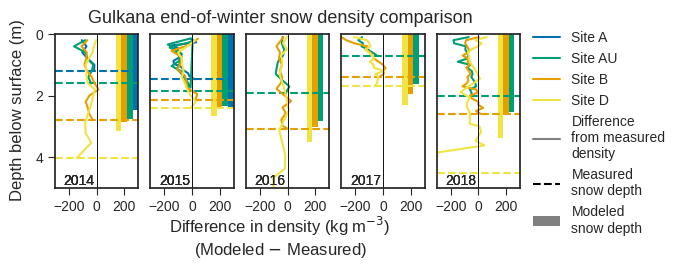

In [ ]:
plot_diff = True
# years = np.arange(2000,2025)
years = np.arange(2014,2019)
with open('../MB_data/pits.pkl', 'rb') as file:
    site_profiles = pickle.load(file)
ds_by_site = {'AU':[],'B':[],'D':[]}
colors = np.flip(['#F0E442','#E69F00','#009E73','#0072B2']) # 
fig,axes = plt.subplots(1,5,figsize=(6,2),sharex=True,sharey=True,gridspec_kw={'hspace':0.12,'wspace':0.15})
axes = axes.flatten()
for ss,site in enumerate(sitedict['long']): # sitedict['long']
    # Select site color
    color = colors[ss]

    # Load data for the site
    profiles = site_profiles[site]
    # if 'run' in result_dict['long'][kw][c5][kp][site]:
    #     run = result_dict['long'][kw][c5][kp][site]['run']
    #     set = result_dict['long'][kw][c5][kp][site]['set']
    #     ds,s,e = getds(base_fp+f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
    # else:
    #     print('missing',site,kw,c5,kp)
    #     continue
    ds,s,e = getds(base_fp+f'Gulkana_2024_11_26_long{site}_0.nc')

    # Loop through years
    for y,year in enumerate(years):
        ax = axes[y]

        # Some years don't have data: skip
        if year in profiles['sbd']:
            # Load data
            sbd = profiles['sbd'][year]
            dens_meas = profiles['density'][year]

            # Load dataset on the date the snowpit was taken
            sample_date = profiles['date'][year]
            dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))

            # Add year to the axis
            coords = [-240,4.9] if plot_diff else [50,4.9]
            ax.text(coords[0],coords[1],str(year),fontsize=10)

            # Calculate layer density and determine snow indices
            ldz = dsyear.layerheight.values
            depth_mod = np.array([np.sum(ldz[:i+1])-(ldz[i]/2) for i in range(len(ldz))])
            dens_mod = dsyear['layerdensity'].values
            snow_idx = np.where(depth_mod < dsyear.snowdepth.values)[0]

            if plot_diff:
                # Interpolate modeled density to the snowpit depths
                dens_interp = np.interp(sbd,depth_mod,dens_mod)
                diff = dens_interp - dens_meas

                # Plot the difference
                ax.plot(diff,profiles['sbd'][year],color=color)
            else:
                # Plot the profiles
                ax.plot(dens_meas,sbd,color=color,linestyle='--')
                ax.plot(dens_mod[snow_idx],depth_mod[snow_idx],color=color)

            # Find the snow depth
            snowdepth_mod = depth_mod[snow_idx[-1]]
            snowdepth_pit = sbd[~np.isnan(sbd)][-1]

            # Plot a horizontal line for the snow depth
            # ax.axhline(snowdepth_mod,color=color)
            # ax.axhline(snowdepth_pit,color=color,linestyle='--')            

            if plot_diff:
                # Plot a bar of the snow depth
                bar_width = 40
                ax.bar(300-(ss+1)*bar_width,snowdepth_mod,width=bar_width,color=color,align='edge')
                ax.axhline(snowdepth_pit,color=color,linestyle='--')

    # Dummy variable for legend
    axes[4].plot(np.nan,np.nan,label=f'Site {site}',color=color)

# Dummy variables for legend
if plot_diff:
    axes[4].plot(np.nan,np.nan,label='Difference\nfrom measured\ndensity',color='grey')
    axes[4].plot(np.nan,np.nan,color='black',linestyle='--',label='Measured\nsnow depth')
    axes[4].bar(np.nan,np.nan,color='gray',label='Modeled\nsnow depth')
else:
    axes[4].plot(np.nan,np.nan,label='Modeled',color='grey')
    axes[4].plot(np.nan,np.nan,label='Measured',color='gray',linestyle='--')

# Format axes
for a,ax in enumerate(axes):
    ax.invert_yaxis()
    ax.set_ylim(5,0)
    ax.set_yticks([0,2,4])
    ax.tick_params(length=5,labelsize=10)
    if plot_diff:
        ax.axvline(0,color='k',linewidth=0.5)
        ax.set_xlim(-300,300)
        ax.set_xticks([-200,0,200])
        fig.supxlabel('Difference in density (kg m$^{-3}$)\n(Modeled $-$ Measured)',fontsize=12,y=-0.25)
    else:
        ax.set_xlim(0,600)
        ax.set_xticks([0,250,500])
        fig.supxlabel('Density (kg m$^{-3}$)',fontsize=12,y=0.04)
    if a % 5 != 0:
        ax.tick_params('y',length=0)
    ax.axvline(0,linewidth=0.5,color='black')
fig.supylabel('Depth below surface (m)',fontsize=12,x=0.05)
axes[4].legend(bbox_to_anchor=(1,1.1))
fig.suptitle(f'Gulkana end-of-winter snow density comparison',fontsize=13,y=1)
plt.savefig(base_fp+'density_pits.png',dpi=180,bbox_inches='tight')
plt.show()

TIMESERIES OF SNOW MASS

NameError: name 'site_profiles' is not defined

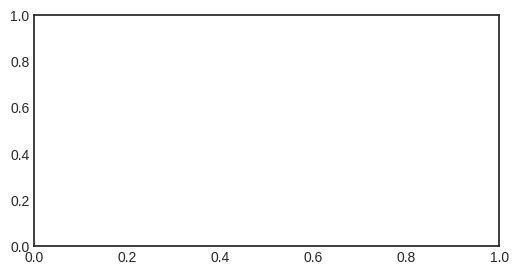

In [ ]:
fig,ax = plt.subplots(figsize=(6,3))
for ss,site in enumerate(['B','AU','A']):
    color = colors[ss+1]
    prof = site_profiles[site]
    snowmass_meas_list = []
    snowmass_mod_list = []
    if 'run' in result_dict['long'][kw][c5][kp][site]:
        run = result_dict['long'][kw][c5][kp][site]['run']
        set = result_dict['long'][kw][c5][kp][site]['set']
        ds,s,e = getds(f'/trace/group/rounce/cvwilson/Output/{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
    else:
        print('missing',site,kw,c5,kp)
        continue
    for year in years:
        year = int(year)
        if year in prof['sbd']:
            sample_heights = np.append(np.array([prof['sbd'][year][0]]),np.diff(np.array(prof['sbd'][year])))
            snowmass_meas = np.sum(prof['density'][year] * sample_heights) / 1000
            snowmass_meas_list.append(snowmass_meas)
        else:
            snowmass_meas_list.append(np.nan)
        
        # Load dataset on the date the snowpit was taken
        if year in profiles['date']:
            sample_date = profiles['date'][year]
        else:
            sample_date = '04-20'
        dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))

        # Calculate layer density and determine snow indices
        ldz = dsyear.layerheight.values
        depth_mod = np.array([np.sum(ldz[:i+1])-(ldz[i]/2) for i in range(len(ldz))])
        dens_mod = dsyear['layerdensity'].values
        snow_idx = np.where(depth_mod < dsyear.snowdepth.values)[0]

        snowmass_mod = np.sum(dsyear.layerheight.values[snow_idx] * dsyear.layerdensity.values[snow_idx]) / 1000
        snowmass_mod_list.append(snowmass_mod)
    ax.plot(years,snowmass_mod_list,color=color)
    ax.plot(years,snowmass_meas_list,color=color,linestyle='--')
ax.tick_params(length=5,labelsize=10)
ax.set_xlim(2000,2024)
ax.set_ylabel('Mass of snow (m w.e.)')
ax.set_title('Spring field date mass of snow (integrated snow pits)')

DIFFERENCE COMPARISON

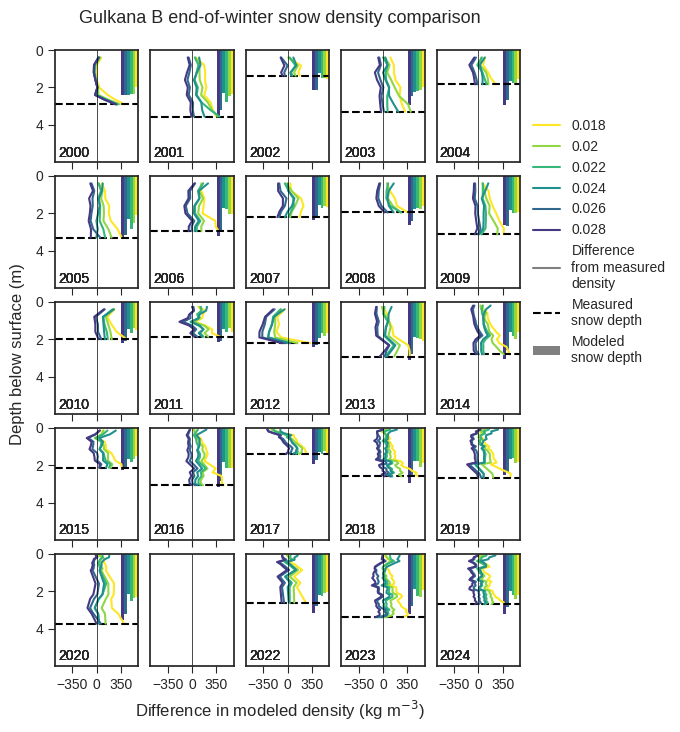

In [ ]:
fig,axes = plt.subplots(5,5,figsize=(6,8),sharex=True,sharey=True,gridspec_kw={'hspace':0.12,'wspace':0.15})
axes = axes.flatten()
norm = mpl.colors.Normalize(vmin=0,vmax=len(params['Boone_c5']))
cmap = mpl.colormaps.get_cmap('viridis_r')
site = 'B'

# Loop through c5 values
for cc,c5 in enumerate(params['Boone_c5']):
    # Grab color for the value
    color = cmap(norm(cc))

    # Load in the datasets for the site
    ds = result_dict['long']
    profiles = site_profiles[site]
    
    # Loop through years (subplots)
    for y,year in enumerate(years):
        ax = axes[y]

        # Some years don't have data: skip
        if year in profiles['sbd']:
            # Load data
            sbd = profiles['sbd'][year]
            dens_meas = profiles['density'][year]

            # Load dataset on the date the snowpit was taken
            sample_date = profiles['date'][year]
            dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))

            # Calculate layer density and determine snow indices
            ldz = dsyear.layerheight.values
            depth_mod = np.array([np.sum(ldz[:i+1])-(ldz[i]/2) for i in range(len(ldz))])
            dens_mod = dsyear['layerdensity'].values
            snow_idx = np.where(depth_mod < dsyear.snowdepth.values)[0]

            # Interpolate modeled density to the snowpit depths
            dens_interp = np.interp(sbd,depth_mod,dens_mod)
            diff = dens_interp - dens_meas

            # Plot the difference
            ax.plot(diff,profiles['sbd'][year],color=color)

            # Add year to the axis
            ax.text(-560,5.7,str(year),fontsize=10)

            # Find the snow depth
            snowdepth_mod = dsyear.snowdepth.values
            snowdepth_pit = sbd[~np.isnan(sbd)][-1]
            
            # Plot a bar of the snow depth
            bar_width = 40
            ax.bar(600-(cc+1)*bar_width,snowdepth_mod,width=bar_width,color=color,align='edge')
            if cc == 0:
                ax.axhline(snowdepth_pit,color='black',linestyle='--')

    # Add dummy variable for legend
    axes[4].plot(np.nan,np.nan,label=c5,color=color)

# Dummy variables for legend
axes[4].plot(np.nan,np.nan,label='Difference\nfrom measured\ndensity',color='grey')
axes[4].plot(np.nan,np.nan,color='black',linestyle='--',label='Measured\nsnow depth')
axes[4].bar(np.nan,np.nan,color='gray',label='Modeled\nsnow depth')

# Format axes
for a,ax in enumerate(axes):
    ax.invert_yaxis()
    ax.set_ylim(6,0)
    ax.set_yticks([0,2,4])
    ax.tick_params(length=5,labelsize=10)
    ax.set_xlim(-600,600)
    ax.set_xticks([-350,0,350])
    if a % 5 != 0:
        ax.tick_params('y',length=0)
    ax.axvline(0,linewidth=0.5,color='black')
fig.supxlabel('Difference in modeled density (kg m$^{-3}$)',fontsize=12,y=0.04)
fig.supylabel('Depth below surface (m)',fontsize=12,x=0.05)
axes[4].legend(bbox_to_anchor=(1,0.5))
fig.suptitle(f'Gulkana {site} end-of-winter snow density comparison',fontsize=13,y=0.93)
# plt.show()
plt.savefig(f'../Output/EB/gulkana{site}_pits_modeled.png',dpi=220,bbox_inches='tight')

Compare albedo

In [11]:
df = pd.read_csv('/trace/home/cvwilson/research/climate_data/AWS/Preprocessed/gulkana2024_walbedo.csv',index_col=0)
df.index = pd.to_datetime(df.index) 
dates = pd.date_range('2024-04-20','2024-08-20',freq='d')
daily_albedo = []

for date in dates:
    start = pd.to_datetime(str(date.date())+' 12:00')
    end = pd.to_datetime(str(date.date())+' 16:00')
    # print(df.loc[start:end,'albedo'].values)
    daily_albedo.append(np.mean(df.loc[start:end,'albedo']))
    if daily_albedo[-1] > 0.85:
        print(date,daily_albedo[-1])

2024-05-05 00:00:00 0.8985525351579542
2024-05-08 00:00:00 0.8726267480729313
2024-05-10 00:00:00 0.8549586872083376
2024-05-11 00:00:00 0.8762035540016896
2024-05-13 00:00:00 0.880089545366238
2024-05-20 00:00:00 0.8818558036530462
2024-05-23 00:00:00 0.8987871217128072
2024-05-24 00:00:00 0.8852996562527409
2024-05-25 00:00:00 0.8538435284959579
2024-05-28 00:00:00 0.8701996034844643
2024-05-30 00:00:00 0.8604443274431901
2024-08-12 00:00:00 0.8789788743064341


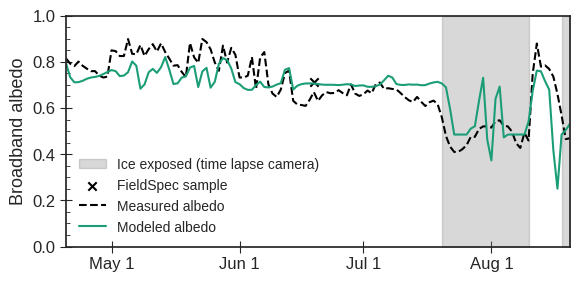

In [65]:
df = pd.read_csv('/trace/home/cvwilson/research/climate_data/AWS/Preprocessed/gulkana2024_walbedo.csv',index_col=0)
df.index = pd.to_datetime(df.index) # - pd.Timedelta(hours=8)
# df['albedo'] = df['SWout'] / df['SWin']
# bds,s,e = getds('../Output/EB/Gulkana_2024_11_24_1.nc')
# bds,s,e = getds('../Output/EB/Gulkana_2024_12_05_0.nc')
bds = bds.resample(time='d').mean()
daily_albedo = []
ice_albedo = []
dates = pd.date_range('2024-04-20','2024-08-20',freq='d')
dates_ice = np.concatenate([pd.date_range('2024-07-20','2024-08-10'),pd.date_range('2024-08-18','2024-08-22')])
for date in dates:
    start = pd.to_datetime(str(date.date())+' 12:00')
    end = pd.to_datetime(str(date.date())+' 16:00')
    # print(df.loc[start:end,'albedo'].values)
    daily_albedo.append(np.mean(df.loc[start:end,'albedo']))
    if date in dates_ice:
        ice_albedo.append(np.mean(df.loc[start:end,'albedo']))
y = np.arange(0,1.1,0.1)
fig,ax = plt.subplots(figsize=(6.5,3))
ax.fill_betweenx(y,[pd.to_datetime('2024-08-10')],[pd.to_datetime('2024-07-20')],color='grey',alpha=0.3,label='Ice exposed (time lapse camera)')
ax.fill_betweenx(y,[pd.to_datetime('2024-08-18')],[pd.to_datetime('2024-08-22')],color='grey',alpha=0.3)
ax.scatter(pd.to_datetime('2024-06-19'),0.7123,marker='x',color='black',label='FieldSpec sample')
ax.plot(dates,daily_albedo,label='Measured albedo',color='black',linestyle='--')
ax.plot(bds.time,bds['albedo'],label='Modeled albedo',color=plt.cm.Dark2(0))

ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(0,1)
ax.tick_params(which='major',labelsize=12,length=8,direction='inout')
ax.minorticks_on()
ax.tick_params(axis='x',which='minor',bottom=False)
ax.tick_params(axis='y',which='minor',length=3,direction='in')
ax.legend(fontsize=10)
ax.set_ylabel('Broadband albedo',fontsize=13)
ax.set_xticks(pd.date_range('2024-04-20',e,freq='MS'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
ax.set_xticklabels(['May 1','Jun 1','Jul 1','Aug 1'])
# ax.set_title(f'Mean ice albedo: {np.mean(ice_albedo):.3f}',fontsize=12)
# fig.suptitle('Daily albedo (mean of 12:00 - 16:00) at Gulkana B, summer 2024',fontsize=13,y=1.03)
plt.savefig(base_fp+'gulkana_albedo_2024.png',dpi=150,bbox_inches='tight')
plt.show()
print()

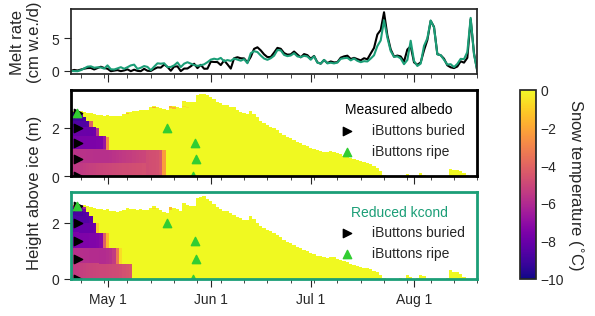

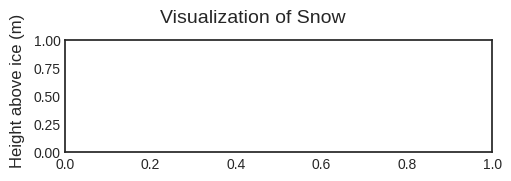

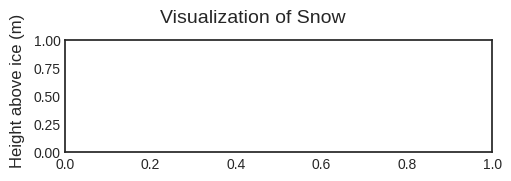

In [86]:
ripe_dict = {'AU': {10: pd.Timestamp('2024-04-21 22:45:00'), 40: pd.Timestamp('2024-04-26 05:30:00'), 80: pd.Timestamp('2024-05-01 14:30:00'), 150: pd.Timestamp('2024-04-27 14:30:00')}, 'B': {10: pd.Timestamp('2024-04-21 21:15:00'), 70: pd.Timestamp('2024-05-18 20:15:00'), 135: pd.Timestamp('2024-05-27 08:45:00'), 200: pd.Timestamp('2024-05-27 11:30:00'), 270: pd.Timestamp('2024-05-26 18:30:00')}, 'D': {10: pd.Timestamp('2024-06-01 18:00:00'), 40: pd.Timestamp('2024-06-02 14:15:00'), 80: pd.Timestamp('2024-06-02 16:45:00'), 120: pd.Timestamp('2024-06-05 14:00:00'), 150: pd.Timestamp('2024-06-05 08:45:00')}}
fig = plt.figure(figsize=(6,3.5))
mosaic = """
        A.
        BD
        CD
"""
ax_dict = fig.subplot_mosaic(mosaic,height_ratios=[1.5,2,2],width_ratios=[1,0.04])
labels = ['Measured albedo','Reduced kcond']
colors = ['black',plt.cm.Dark2(0)]
site = 'B'
for id in [0,1]:
    ripe_dates = {}
    # iidd = 1 if id == 0 else 0
    # # ds,s,e = getds(base_fp + f'Gulkana_11_26_2024B_{iidd}.nc')
    # ds,s,e = getds(f'../Output/EB/Gulkana_2024_12_05_{iidd}.nc')
    if id == 0:
        ds,s,e = getds(f'../Output/EB/Gulkana_2024_12_05_1.nc')
    elif id == 1:
        ds,s,e = getds('/trace/group/rounce/cvwilson/Output/Gulkana_12_19_2024B_2.nc')
    ax_letter = 'B' if id == 0 else 'C'
    if site =='D':
        ax_dict[ax_letter] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'],ylim=10,plot_ax=[ax_dict[ax_letter]],colorbar=False)[0]
    else:
        ax_dict[ax_letter] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'],plot_ax=[ax_dict[ax_letter]],colorbar=False)[0]
    ax = ax_dict[ax_letter]

    # Scatter initial heights of iButtons
    depths = np.array([f for f in ripe_dict[site]])
    heights = depths[-1] - depths
    start = np.array([pd.to_datetime('2024-04-22') for _ in range(len(heights))])
    if site == 'D':
        heights += 1200
    ax.scatter(start,heights/100,color='black',marker='>',label='iButtons buried')
    
    # Scatter ripened dates for each sensor
    for depth in ripe_dict[site]:
        if site != 'B':
            height = 150 - depth
        else:
            height = 270 - depth
        if site == 'D':
            height += 1200
        ax.scatter(ripe_dict[site][depth],height/100,marker='^',color='limegreen')
    ax.scatter(np.nan,np.nan,marker='^',color='limegreen',label='iButtons ripe')

    # Add melt rates
    ds = ds.resample(time='d').sum()
    ax_dict['A'].plot(ds.time.values,ds.melt.values*100,label=labels[id],color=colors[id]) # ,width=pd.Timedelta(hours=25)
    ax_dict['A'].set_ylabel('Melt rate\n(cm w.e./d)',fontsize=12)
    ax_dict['A'].yaxis.set_label_coords(-0.07,0.5)
    ax_dict['A'].tick_params(length=5)
    # ax_dict['A'].legend(fontsize=10)
    leg = ax.legend(title=labels[id])
    leg.get_title().set_color(colors[id])
    ax.yaxis.grid(True)
    for spine in ax.spines.values():
        spine.set_edgecolor(colors[id])
        spine.set_linewidth(2)
ax.set_ylabel('Height above ice (m)',fontsize=12)
ax.yaxis.set_label_coords(-0.07,1)
    
for aaa in ['A','B','C']:
    ax.grid(False)
    ax = ax_dict[aaa]
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
    ax.tick_params(axis='x',which='major', direction='out', length=6)
    ax.minorticks_on()
    ax.set_xticks(pd.date_range('2024-04-20','2024-08-20',freq='MS'))
    ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-20'))
    ax.tick_params(axis='y',which='minor',bottom=False)
    ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(interval=1))
    ax.tick_params(axis='x',which='minor', direction='out', length=3)
    ax.set_xticklabels([])
ax_dict['C'].set_xticklabels(['May 1','Jun 1','Jul 1','Aug 1'])
sm = mpl.cm.ScalarMappable(cmap='plasma',norm=plt.Normalize(-10,0))
cb = fig.colorbar(sm,aspect=7,fraction=0.02,orientation='vertical',cax=ax_dict['D'])
cb.set_label('Snow temperature ($^{\circ}$C)',rotation=270,labelpad=15,fontsize=12)
# plt.show()
# fig.savefig(base_fp + 'snow_ripening.png',dpi=180,bbox_inches='tight')

Additional plots that are useful to understand tradeoffs

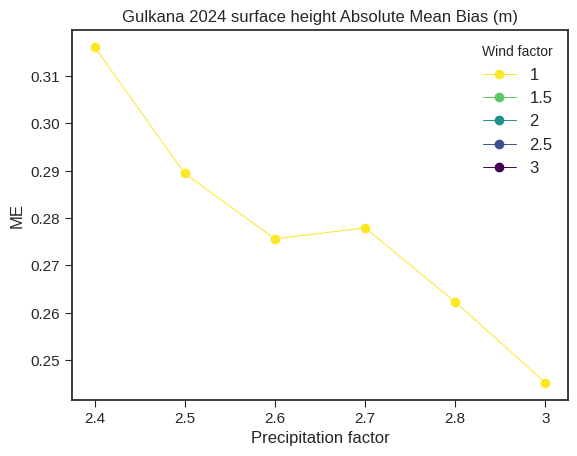

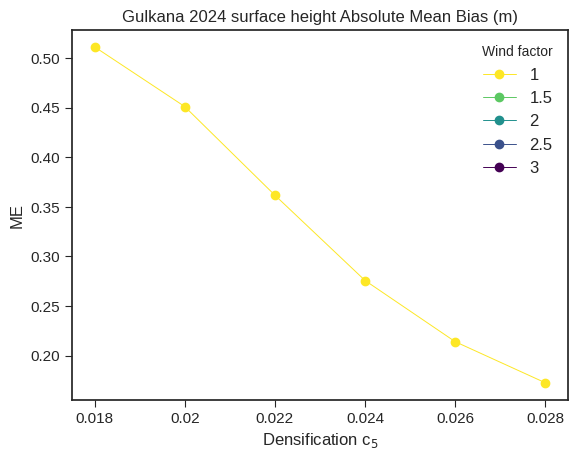

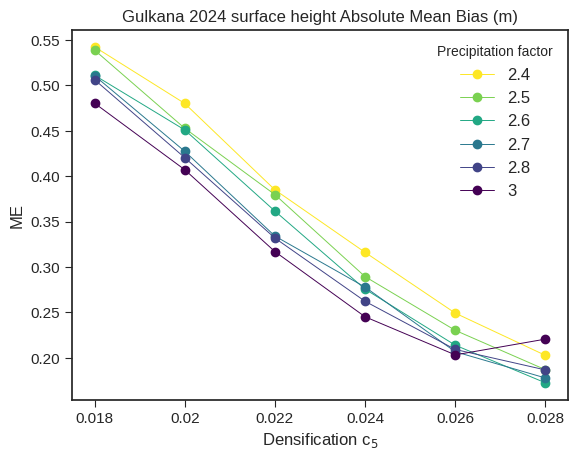

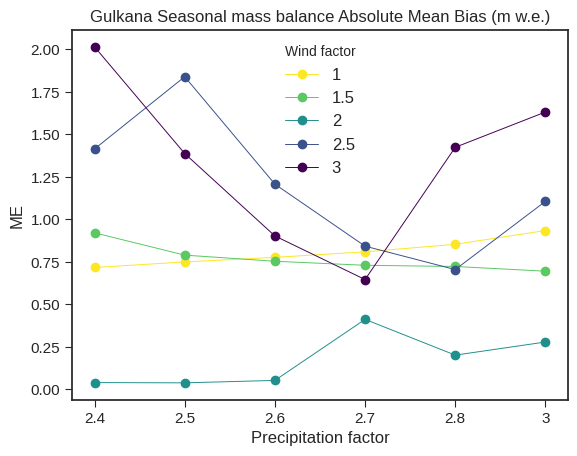

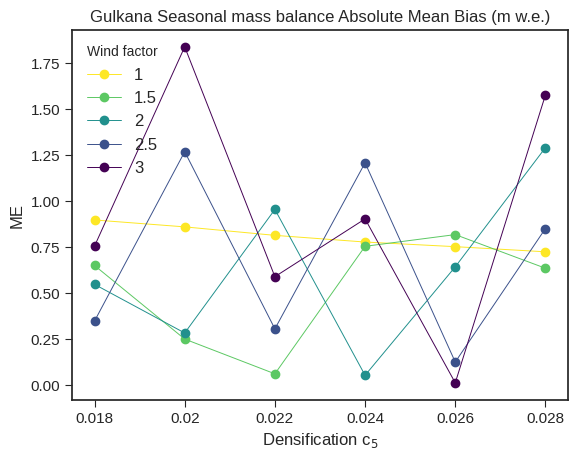

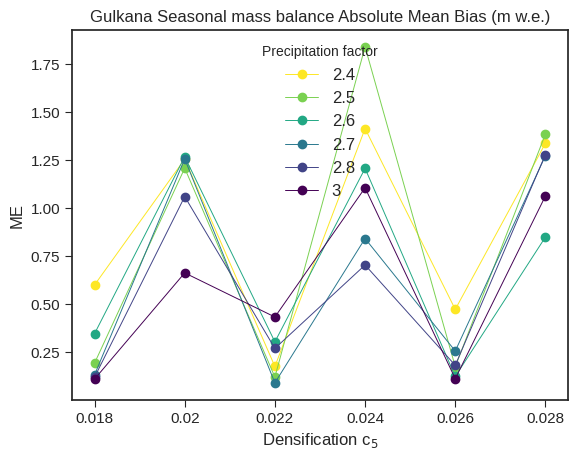

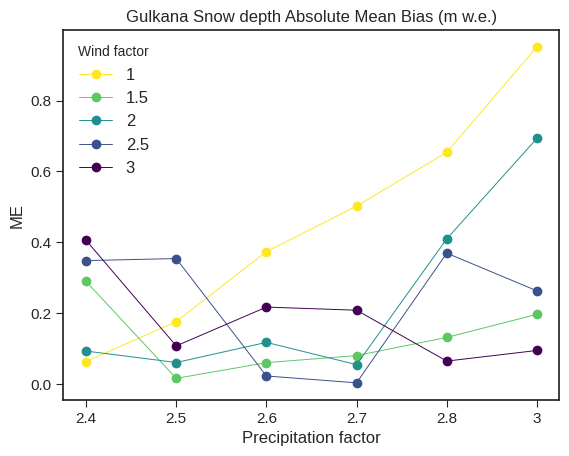

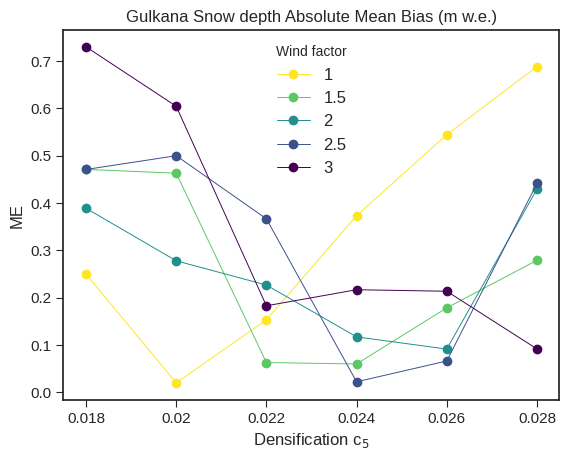

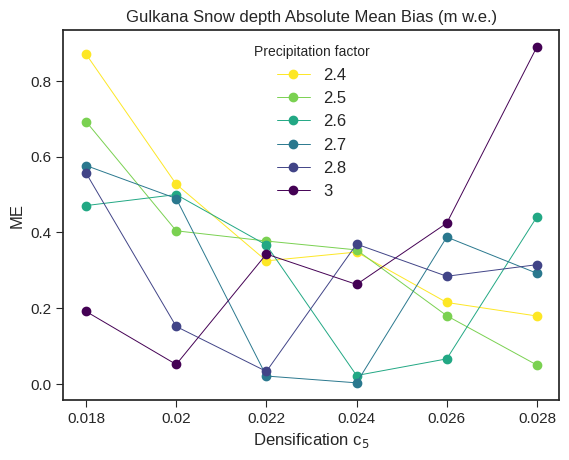

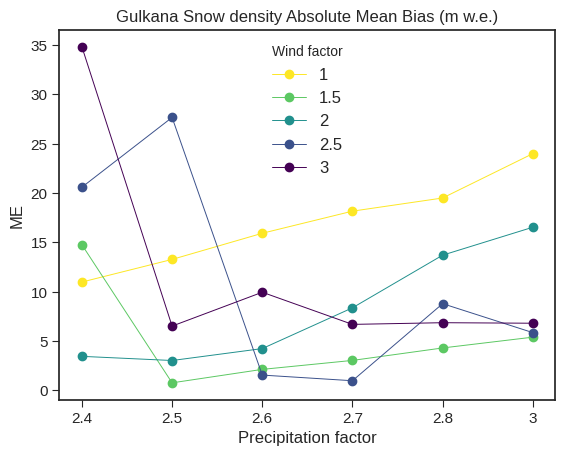

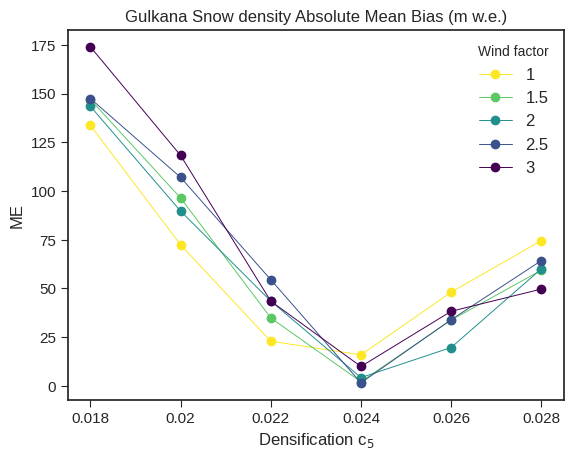

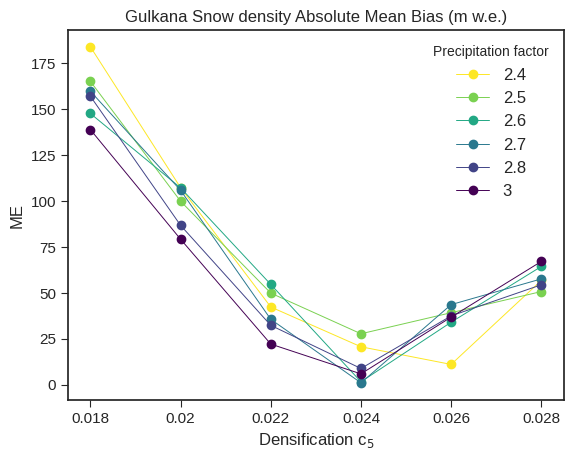

In [35]:
for error_name in ['2024','seasonal','snowdepth','snowdensity']: # '2024']: # 
    # Parse run info
    run = '2024' if error_name == '2024' else 'long'
    error_name += '_' + metric
    
    # if run_name == '2024':
    #     param_x = 'kp'
    #     param_z = 'Boone_c5'
    # elif run_name == 'winter':
    #     param_x = 'kw'
    #     param_z = 'kp'
    # elif run_name == 'summer':
    #     param_x = 'kw'
    #     param_z = 'kp'
    # elif run_name == 'long':
    #     param_x = 'kp'
    #     param_z = 'Boone_c5'
    
    all_sites = sitedict[run]+['mean']

    for (param_x,param_z) in [['kp','kw'],['Boone_c5','kw'],['Boone_c5','kp']]:
        for site in ['mean']:
            fig,ax = plt.subplots()
            param_x_arr = np.array(params[param_x],dtype=str)
            param_z_arr = np.array(params[param_z],dtype=str)
            errors = np.empty([len(param_x_arr),len(param_z_arr)])

            if 'kw' not in [param_x,param_z]:
                kw = medians['kw']
                if run == 'long':
                    kw = '2.5'
            if 'kp' not in [param_x,param_z]:
                kp = medians['kp']
            if 'Boone_c5' not in [param_x,param_z]:
                c5 = medians['Boone_c5']

            norm = mpl.colors.Normalize(vmin=0,vmax=len(param_z_arr)-1)
            cmap = mpl.colormaps.get_cmap('viridis_r')
            for zz,zval in enumerate(param_z_arr):
                for xx,xval in enumerate(param_x_arr):
                    if param_x == 'kw':
                        kw = xval
                    elif param_z == 'kw':
                        kw = zval
                    if param_x == 'kp':
                        kp = xval
                    elif param_z == 'kp':
                        kp = zval
                    if param_x == 'Boone_c5':
                        c5 = xval
                    elif param_z == 'Boone_c5':
                        c5 = zval

                    if error_name in result_dict[kw][c5][kp][site]:
                        errors[xx,zz] = result_dict[kw][c5][kp][site][error_name]
                    else:
                        errors[xx,zz] = np.nan
                errors = np.abs(errors)
                ax.plot(param_x_arr,errors[:,zz],color=cmap(norm(zz)),label=str(zval),marker='o',linewidth=0.7)
            ax.legend(title=labels[param_z],fontsize=12)
            ax.set_xlabel(labels[param_x],fontsize=12)
            ax.set_ylabel(method,fontsize=12)
            units = 'm w.e.' if run == 'long' else 'm'
            error_label = shorterrorlabels[error_name.split('_')[0]]
            title = f'{error_label} {methodlabels[method]} ({units})'
            if site != 'mean':
                title += f' at site {site}'
            ax.set_title(title)
            ax.tick_params(length=5,labelsize=11)
            # plt.savefig(f'../Output/EB/{param_z}_vs_{param_x}_{run_name}_{site}.png')
            plt.show()

In [ ]:
# ===== Find best parameter sets using one error metric (OUTDATED APPROACH) =====
min_err = np.inf
min_long_err = np.inf
min_2024_err = np.inf
method = 'ME'
for kw in params['kw']:
    # kw = '1'
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            summer_error = []
            winter_error = []
            density_error = []
            s24 = []
            # Find mean long run error across sites and seasons
            if 'long' in result_dict:
                for site in sitedict['long']:
                    if 'summer_'+method in result_dict['long'][kw][c5][kp][site]:
                        summer_error.append(np.abs(result_dict['long'][kw][c5][kp][site][f'summer_{method}']))
                        winter_error.append(np.abs(result_dict['long'][kw][c5][kp][site][f'winter_{method}']))
                        # density_error.append(np.abs(result_dict['long'][site]['1'][c5][kp][f'density_{method}'])/100)
                meanlong = np.mean([summer_error,winter_error]) # 
                if meanlong < min_long_err: # and len(summer_error) == 3:
                    min_long_err = meanlong
                    best_long = [kw,c5,kp]
            # Find mean short run error across sites
            if '2024' in result_dict:
                for site in sitedict['2024']:
                    if method in result_dict['2024'][site]['1'][c5][kp]:
                        s24.append(np.abs(result_dict['2024'][site]['1'][c5][kp][method]))
                mean24 = np.mean(s24)
                if mean24 < min_2024_err:
                    min_2024_err = mean24
                    best_2024 = [kw,c5,kp]
            # Find best overall error
            if '2024' in result_dict and 'long' in result_dict:
                err = np.mean([meanlong,mean24])
                if err < min_err:
                    min_err = err
                    best = [kw,c5,kp]

kw,c5,kp = best_long
print(kw,c5,kp,min_long_err)
kw,c5,kp = best_2024
print(kw,c5,kp,min_2024_err)
kw,c5,kp = best
print(kw,c5,kp,min_err)